# What's Cooking?
**Use recipe ingredients to categorize the cuisine**

------------------------------------------------------------------------------

**By** [**Mohamed Maher**](https://www.linkedin.com/in/mohamedmaher17/) **June-2020**.

# Table of Contents

- [Introduction](#Introduction)
- [Data Type and Attributes](#Data-Type-and-Attributes)
- [Environment and Configurations](#Environment-and-Configurations)
- [Data Loading](#Data-Loading)
- [Data Exploration](#Data-Exploration)
- [Data Pipeline](#Data-Pipeline)
    - [Pipeline Introduction](#Pipeline-Introduction) 
    - [Data Preprocessing](#Data-Preprocessing)
    - [Feature Extraction](#Feature-Extraction)
    - [Data Classifiers (ML Models)](#Data-Classifiers-(ML-Models))
    - [Pipelines](#Pipelines)
- [Training and Validation](#Training-and-Validation)
- [Grid Search](#Grid-Search)
- [Train Best Model Again](#Train-Best-Model-Again)
- [Submission File](#Submission-File)

## Introduction

In this Notebook, I gonna discuss [What's Cooking?](https://www.kaggle.com/c/whats-cooking/overview) challenge on [Kaggle](https://www.kaggle.com/). simply it is a classification problem, based on ingredients, we should classify the type of cuisine.

In this kernel I will tell you how **81%** accuracy model achived !!.

Let's start .. 🤩

## Data Type and Attributes

Challenge provided [data](https://www.kaggle.com/c/whats-cooking/data) are splitted into two files **(train/test)** in [JSON](https://en.wikipedia.org/wiki/JSON) format.

Here we will use train file as **training** and **validation** data, as test file is for kaggle final submission only ***(no label exists)***.

Train file:

- **``id``**: recipes id
- **``cuisine``**: type of cuisine (i.e. indian, greek .. etc)
- **``ingredients``**: list of ingredients (i.e. water, oil, wheat .. etc)

Sample row of Train File:
> { <br/>
> "id": 24717, <br/>
> "cuisine": "indian", <br/>
> "ingredients": [<br/>
>     "tumeric", <br/>
>     "vegetable stock", <br/>
>     "tomatoes", <br/>
>     "garam masala", <br/>
>     "naan", <br/>
>     "red lentils", <br/>
>     "red chili peppers", <br/>
>     "onions", <br/>
>     "spinach", <br/>
>     "sweet potatoes" <br/>
> ] <br/>
> } <br/>


Test file:
- **``id``**: recipes id
- **``cuisine``**: type of cuisine

## Environment and Configurations

Below are most used Python Data Science pckages ..

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import re
import pandas as pd
import os
from collections import defaultdict

#----------- sklearn ------------------------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
#-------------- xgboost -------------------------- 
from xgboost import XGBClassifier
#----------- keras ------------------------------
from keras.preprocessing.text import Tokenizer
#----------- gensim ------------------------------
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#----------- NLTK ------------------------------
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords



Using TensorFlow backend.


Pandas columns and rows display configurations ..

In [3]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 400)

Changing the relative path for the case's working directory.

<span style= "color:red" > Note: </span> In case you will use this kernel you have to change the below path

In [4]:
path = 'D:/2- Kaggle/8-Whats Cooking/'
os.chdir(path)

## Data Loading

Reading the (train/test) data located in **data** directory..

In [5]:
train_row_df = pd.read_json('data/train.json')
test_row_df = pd.read_json('data/test.json')

## Data Exploration

In this part we will explore the data **shapes** (no. of rows and columns), data **samples** and **cuisine data distribution** as percentage.

In [6]:
train_row_df.shape

(39774, 3)

In [7]:
test_row_df.shape

(9944, 2)

In [8]:
train_row_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


As we see above the **ingredients** are in **list** format, and we can see that there are two words and more as a single ingredient like **'romaine lettuce'** and **'ground black pepper'** for example, and we expect to see this in test file also.

In [9]:
test_row_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisins, milk, white sugar]"
1,28583,"[sugar, egg yolks, corn starch, cream of tartar, bananas, vanilla wafers, milk, vanilla extract, toasted pecans, egg whites, light rum]"
2,41580,"[sausage links, fennel bulb, fronds, olive oil, cuban peppers, onions]"
3,29752,"[meat cuts, file powder, smoked sausage, okra, shrimp, andouille sausage, water, paprika, hot sauce, garlic cloves, browning, lump crab meat, vegetable oil, all-purpose flour, freshly ground pepper, flat leaf parsley, boneless chicken skinless thigh, dried thyme, white rice, yellow onion, ham]"
4,35687,"[ground black pepper, salt, sausage casings, leeks, parmigiano reggiano cheese, cornmeal, water, extra-virgin olive oil]"


Below figure is the data distributions percentages on cuisine dimension..

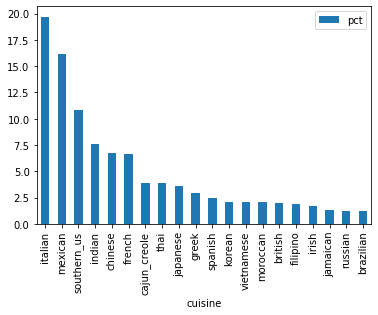

In [10]:
train_row_df.groupby('cuisine')\
            .agg(
                count = ('ingredients', 'count')
            )\
            .sort_values(by = ['count'],ascending= False)\
            .assign(
                total_cnt = lambda x : x['count'].sum()\
                ,pct = lambda x : (x['count'] / x['total_cnt']) * 100  
            )\
            .reset_index()\
            .plot.bar(x='cuisine', y='pct')

Data totally imbalanced !!. click [here](https://www.kaggle.com/getting-started/100018) for more info about imbalanced data it's challenges. 

## Data Pipeline

I would like to explain the technique of [**sklearn Pipeline**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) <blockquote>as [@dbaghern](https://www.kaggle.com/baghern) said in her awesome [notebook](https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines): **Pipelines** are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.</blockquote>

My pipeline will go as follow :
![image.png](Images/pipeline.png)


### Data Preprocessing

Here I will bulid the preprocessing class of our pipeline, applying basic simple text preprocessing steps as follow:

- Concating multi-words ingredient, and it will be an **optional step**, as I was checking if it will increase my accuracy or not (I will not use it in preprocessing) .. it is descreasing accuracy.
- Convert list of ingredients to string
- Remove all bad symbols from the the string
- Remove stopwords 

In [11]:
class text_preprocessing(TransformerMixin):
    
    def __init__(self, concat_ingredients = False):
        self.concat_ingredients = concat_ingredients
        
    def transform(self, ingredients):
        BAD_SYMBOLS_RE = re.compile('[^0-9a-z]')
        STOPWORDS = set(stopwords.words('english'))

        if(self.concat_ingredients):
            ingredients = ingredients.apply(lambda ing_list: [ingredient.replace(' ','') for ingredient in ing_list]) # concat multi word ingredient 

        ingredients = ingredients.apply(lambda ing_list: ' '.join(ing_list)) # convert list of ingredients to string
        ingredients = ingredients.str.lower() # ingredients string to lower case letters
        ingredients = ingredients.apply(lambda ing_list: BAD_SYMBOLS_RE.sub(' ', ing_list)) # remove all non(numbers, characters) from the string
        ingredients = ingredients.apply(lambda ing_list: ' '.join([word for word in ing_list.split() if word not in STOPWORDS])) # remove stopwords       
        
        return ingredients
    
    def fit(self, X, Y):
        return self

As I mentioned before that we will split train file data into train and validation, I decided to make it **(70% train and 30% validation)** and test will be for kaggle final result submission.

In [12]:
X , Y = train_row_df['ingredients'], train_row_df['cuisine']

In [13]:
validation_size = 0.3
random_state = 42

In [14]:
x_train, x_vald , y_train , y_vald = train_test_split(X, Y, test_size = validation_size, random_state = random_state)

x_test = test_row_df['ingredients']

### Feature Extraction

In this step we will use **TfidfTransformer**, [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) is feature representation technique, and it is mandatoury to use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) as step before, or you can use [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) as it is Equivalent to CountVectorizer followed by TfidfTransformer.

And why I took the two steps ?! the answer is that we can use **CountVectorizer** only as features representer, i used it in model train trails.

### Data Classifiers (ML Models)

Using many known classifiers with their defualt parameters, and after training we will get the model with the highest accuracy and apply the grid search to finde best other parameters that boost algorithm to achive more accuracy.

Classifiers Used:

- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html): as simple [baseline](https://datascience.stackexchange.com/questions/30912/what-does-baseline-mean-in-the-context-of-machine-learning) algorithm
- [SGD Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [SVM Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [XGB Classifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
- [KNeighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

### Pipelines

We will create a pipeline for each Classifiers and a dictionary to contain all created pipelines. 

In [15]:
pipelines = defaultdict(None)

NB_Pipeline = Pipeline([
               ('pre', text_preprocessing()),
               ('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])
pipelines['Multinomial Naive Bayes'] = NB_Pipeline


SGD_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf' , SGDClassifier())
              ])
pipelines['SGDClassifier'] = SGD_Pipeline


LR_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())
              ])
pipelines['LogisticRegression'] = LR_Pipeline


RF_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())
              ])
pipelines['RandomForestClassifier'] = RF_Pipeline


SVC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC())
              ])
pipelines['SVMClassifier'] = SVC_Pipeline


GBC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier())
              ])
pipelines['GradientBoostingClassifier'] = GBC_Pipeline


XGBC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective="multi:softprob", random_state=42))
              ])
pipelines['XGBClassifier'] = XGBC_Pipeline


KNC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())
              ])
pipelines['KNeighborsClassifier'] = KNC_Pipeline

### Training and Validation

we will train all models then find best accuracy on validation data

In [18]:
for name, pipeline in pipelines.items():
    pipeline.fit(x_train,y_train)

In [19]:
best_accuracy=0.0
best_classifier_name = 0

for name,model in pipelines.items():
    score = model.score(x_vald, y_vald)
    if score > best_accuracy:
        best_accuracy = score
        best_classifier_name = name 
        
    print(f'''{name} Test Accuracy: {score}''')

print('--------------------------------------------------------')
print(f'''Best Pipeline is {best_classifier_name} with Accuracy {best_accuracy}''')

Multinomial Naive Bayes Test Accuracy: 0.6698231794184195
SGDClassifier Test Accuracy: 0.7734852928852761
LogisticRegression Test Accuracy: 0.7795189809771222
RandomForestClassifier Test Accuracy: 0.7419760328500796
SVMClassifier Test Accuracy: 0.795608815888712
GradientBoostingClassifier Test Accuracy: 0.7358585435347356
XGBClassifier Test Accuracy: 0.7285678370904215
KNeighborsClassifier Test Accuracy: 0.7275622224084471
--------------------------------------------------------
Best Pipeline is SVMClassifier with Accuracy 0.795608815888712


As we see the model with best accuracy is the **SVMClassifier**, so we gonna apply grid search to find best parameters to see if we can get higher accuracy..

### Grid Search

As per **SVMClassifier** documentation there are alot of parameters we can tune, so I select the most relevant parameters as below, note that you have to include all **DEFAULT** parameters as it achived the highest accuracy above we don't want less accuracy 

In [16]:
tuned_parameters = {
                    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                    'clf__degree': [3,4,5],
                    'clf__C': [1, 10, 100, 1000],
                    'clf__decision_function_shape' : ['ovo', 'ovr'],
                    'clf__gamma': ['scale', 'auto']
                    }

Note that **'clf__'** is to that this parameter is one of **'clf'** step in the pipeline 

Using the awesome example [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) we applyed the grid search on **SVC_Pipeline**.

<span style= 'color:red'> WARNING </span> it took around **24 hours** with **4 parallel jobs** (n_jobs parameter below) to get best parameters. 

In [352]:
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    grid = GridSearchCV(SVC_Pipeline, param_grid = tuned_parameters, scoring= score, verbose = 5, n_jobs = 4)
    grid.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_vald, grid.predict(x_vald)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 37.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 83.1min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 150.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 242.0min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 346.1min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed: 460.4min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 595.7min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed: 622.7min finished


[LibSVM]Best parameters set found on development set:

{'clf__C': 10, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Grid scores on development set:

0.778 (+/-0.007) for {'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
0.750 (+/-0.007) for {'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'poly'}
0.788 (+/-0.006) for {'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
0.766 (+/-0.008) for {'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid'}
nan (+/-nan) for {'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'precomputed'}
0.778 (+/-0.007) for {'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__degree': 3, 'clf_

After a loooong time run, we found that best parameters are:
> { <br>
    'clf__C': 10, <br>
    'clf__decision_function_shape': 'ovo', <br>
    'clf__gamma': 'scale', <br>
    'clf__kernel': 'rbf' <br>
    }

### Train Best Model Again

we will now re-train the model will whole train file data (train+vald) so more data may increase the accuracy ..

In [17]:
SVC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(
                            C= 10,
                            decision_function_shape= 'ovo',
                            gamma= 'scale',
                            kernel= 'rbf'
                            )) # best parameters(GSearch)
              ])

SVC_Pipeline.fit(X , Y )

Pipeline(memory=None,
         steps=[('pre',
                 <__main__.text_preprocessing object at 0x0000028A96A817B8>),
                ('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None...
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decis

### Submission File

we gonna store the final predicted output then we will submit the file to be evaluated by Kaggle

In [19]:
pd.DataFrame(
             { 'id' : test_row_df['id'],
               'cuisine': SVC_Pipeline.predict(x_test)
             }
            )\
  .to_csv("data/submission.csv", index=False)

And here is the Kaggle Evaluation result 🥳🥳🥳 ..

![image.png](Images/score.png)